# Preprocessing the Data
---

The first model I plan to make will utilize temperature data from the surface mooring and CTD-O variables from the 200 meter platform in 2017. The steps that need to be completed before modeling include: 
* find proportion of missing data - then drop or impute it accordingly
* resample to lower resolution to reduce number of observations to pass to model
* create new dataframe containing the target variable and features
* save clean dataframe as csv

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from scipy import stats

sns.set()

---
### Load data

Read in the surface mooring and 200m platform data.

In [2]:
METBK_data = pd.read_csv('../../coastal_upwelling_output/metbk_data_2017.csv')
platform_data = pd.read_csv('../../coastal_upwelling_output/platform_data_2017.csv')

In [3]:
CUTI_data = pd.read_csv('../../coastal_upwelling_output/CUTI_daily.csv',
                  parse_dates=[[0,1,2]],
                  infer_datetime_format=True)
CUTI_data.rename(columns={'year_month_day':'time'},inplace=True)

In [4]:
METBK_data['time'] = pd.to_datetime(METBK_data['time'])
platform_data['time'] = pd.to_datetime(platform_data['time'])

---
### Drop unwanted columns

The goal of this project is to identify upwelling using environmental variables in the ocean, like seawater temperature and salinity. Since this is the goal, we actually don't need the wind data collected by the METBK package. Unforunately, I also have to drop the dissolved oxygen measurements collected by the 200 meter platform due to the instrument malfunctioning or being uncalibrated for a significant period of time in 2017.

I'll be combining the datasets along the column labeled `'time'`, but I'll want to drop that column when I'm done, too.

In [5]:
METBK_data.drop(columns=['met_windavg_mag_corr_east', 'met_windavg_mag_corr_north'], inplace=True)
METBK_data

,time,sea_surface_temperature
0,2017-01-01 00:00:30.432000000,11.273
1,2017-01-01 00:01:37.298999808,11.268
2,2017-01-01 00:02:41.522000384,11.267
3,2017-01-01 00:03:46.300000256,11.267
4,2017-01-01 00:04:50.525000192,11.278
...,...,...
485132,2017-12-01 18:28:40.451000320,12.053
485133,2017-12-01 18:29:44.697999872,12.053
485134,2017-12-01 18:30:16.942000128,12.052
485135,2017-12-01 18:31:21.691999744,12.052


In [6]:
platform_data.drop(columns=['seawater_pressure', 'dissolved_oxygen'], inplace=True)
platform_data

,time,density,practical_salinity,seawater_temperature
0,2017-01-01 00:00:00.358334464,1027.258302,33.916341,7.767863
1,2017-01-01 00:00:01.358341632,1027.258472,33.916495,7.767433
2,2017-01-01 00:00:02.358451712,1027.258521,33.916536,7.767187
3,2017-01-01 00:00:03.358353408,1027.258479,33.916442,7.766941
4,2017-01-01 00:00:04.359924736,1027.258647,33.916615,7.766695
...,...,...,...,...
21413150,2017-09-16 12:13:36.463305728,1026.694767,33.802832,8.837725
21413151,2017-09-16 12:13:37.463519744,1026.693119,33.802465,8.838104
21413152,2017-09-16 12:13:38.463524352,1026.692393,33.802463,8.838041
21413153,2017-09-16 12:13:39.464573440,1026.691110,33.802138,8.838483


---
### Combine the data

Let's merge these three dataframes into one on the `time` column. Then we won't waste any time looking for nulls or filled values in data that we aren't going to be using. To start, we should slice the METBK dataframe to cover the same time period as the platform data.

In [7]:
platform_data['time'].tail()

21413150   2017-09-16 12:13:36.463305728
21413151   2017-09-16 12:13:37.463519744
21413152   2017-09-16 12:13:38.463524352
21413153   2017-09-16 12:13:39.464573440
21413154   2017-09-16 12:13:40.463225344
Name: time, dtype: datetime64[ns]

Then use it in a mask to slice the METBK data to match.

In [8]:
mask = (METBK_data['time'][:] > '2017-01-01') & (METBK_data['time'] <= '2017-09-16')
METBK_data = METBK_data.loc[mask]

mask = (platform_data['time'][:] > '2017-01-01') & (platform_data['time'] <= '2017-09-16')
platform_data = platform_data.loc[mask]

In [9]:
METBK_data['time'].tail()

372170   2017-09-15 23:55:29.374000128
372171   2017-09-15 23:56:33.941000192
372172   2017-09-15 23:57:38.194000384
372173   2017-09-15 23:58:42.480999936
372174   2017-09-15 23:59:46.709000192
Name: time, dtype: datetime64[ns]

Next, we should resample the platform data into 1 hour intervals so it's closer to the time interval seen in the METBK data.

In [10]:
METBK_data['time'][:20]

0    2017-01-01 00:00:30.432000000
1    2017-01-01 00:01:37.298999808
2    2017-01-01 00:02:41.522000384
3    2017-01-01 00:03:46.300000256
4    2017-01-01 00:04:50.525000192
5    2017-01-01 00:05:54.762999808
6    2017-01-01 00:06:58.998000128
7    2017-01-01 00:07:31.111000064
8    2017-01-01 00:08:36.003999744
9    2017-01-01 00:09:40.264000000
10   2017-01-01 00:10:44.499999744
11   2017-01-01 00:11:49.525000192
12   2017-01-01 00:12:56.161999872
13   2017-01-01 00:13:30.575000064
14   2017-01-01 00:14:34.812999680
15   2017-01-01 00:15:38.352999936
16   2017-01-01 00:16:42.584999936
17   2017-01-01 00:17:47.187000320
18   2017-01-01 00:18:51.496999936
19   2017-01-01 00:19:55.993999872
Name: time, dtype: datetime64[ns]

In [11]:
platform_data['time'][:20]

0    2017-01-01 00:00:00.358334464
1    2017-01-01 00:00:01.358341632
2    2017-01-01 00:00:02.358451712
3    2017-01-01 00:00:03.358353408
4    2017-01-01 00:00:04.359924736
5    2017-01-01 00:00:05.358471680
6    2017-01-01 00:00:06.358373888
7    2017-01-01 00:00:07.358381568
8    2017-01-01 00:00:08.358491648
9    2017-01-01 00:00:09.358393856
10   2017-01-01 00:00:10.358401536
11   2017-01-01 00:00:11.358616064
12   2017-01-01 00:00:12.358309888
13   2017-01-01 00:00:13.358525952
14   2017-01-01 00:00:14.359156736
15   2017-01-01 00:00:15.358537728
16   2017-01-01 00:00:16.358440960
17   2017-01-01 00:00:17.358550528
18   2017-01-01 00:00:18.358349824
19   2017-01-01 00:00:19.358460928
Name: time, dtype: datetime64[ns]

Unfortunately, it looks like the METBK data is collected at inconsistent intervals. I want to see if resampling the 

In [12]:
platform_min = platform_data.resample('T', on='time').mean().dropna(how='all').reset_index()
print(platform_min.shape)

(356206, 4)


In [13]:
METBK_min = METBK_data.resample('T', on='time').mean().dropna(how='all').reset_index()
print(METBK_min.shape)

(346333, 2)


In [14]:
platform_min['time']

0        2017-01-01 00:00:00
1        2017-01-01 00:01:00
2        2017-01-01 00:02:00
3        2017-01-01 00:03:00
4        2017-01-01 00:04:00
                 ...        
356201   2017-09-15 23:55:00
356202   2017-09-15 23:56:00
356203   2017-09-15 23:57:00
356204   2017-09-15 23:58:00
356205   2017-09-15 23:59:00
Name: time, Length: 356206, dtype: datetime64[ns]

In [15]:
METBK_min['time']

0        2017-01-01 00:00:00
1        2017-01-01 00:01:00
2        2017-01-01 00:02:00
3        2017-01-01 00:03:00
4        2017-01-01 00:04:00
                 ...        
346328   2017-09-15 23:55:00
346329   2017-09-15 23:56:00
346330   2017-09-15 23:57:00
346331   2017-09-15 23:58:00
346332   2017-09-15 23:59:00
Name: time, Length: 346333, dtype: datetime64[ns]

In [16]:
indices = []
for i in range(len(METBK_min['time'])):
    if METBK_min['time'][i] != platform_min['time'][i]:
        indices.append(i)

In [17]:
len(indices)

345535

In [18]:
platform_min

,time,density,practical_salinity,seawater_temperature
0,2017-01-01 00:00:00,1027.258767,33.916755,7.766451
1,2017-01-01 00:01:00,1027.260164,33.917475,7.760876
2,2017-01-01 00:02:00,1027.258920,33.917249,7.767207
3,2017-01-01 00:03:00,1027.258097,33.916964,7.771317
4,2017-01-01 00:04:00,1027.258173,33.917076,7.771017
...,...,...,...,...
356201,2017-09-15 23:55:00,1027.366397,33.960043,7.866675
356202,2017-09-15 23:56:00,1027.366555,33.960125,7.866182
356203,2017-09-15 23:57:00,1027.365319,33.959667,7.872284
356204,2017-09-15 23:58:00,1027.364325,33.959192,7.876495


In [19]:
METBK_min

,time,sea_surface_temperature
0,2017-01-01 00:00:00,11.273
1,2017-01-01 00:01:00,11.268
2,2017-01-01 00:02:00,11.267
3,2017-01-01 00:03:00,11.267
4,2017-01-01 00:04:00,11.278
...,...,...
346328,2017-09-15 23:55:00,15.198
346329,2017-09-15 23:56:00,15.171
346330,2017-09-15 23:57:00,15.158
346331,2017-09-15 23:58:00,15.199


In [20]:
df = pd.merge(platform_min, METBK_min, on='time', how='right')

In [21]:
print(platform_min.shape)
print(METBK_min.shape)
print(df.shape)

(356206, 4)
(346333, 2)
(346333, 5)


Let's check out the percentage of our data that is filled with nulls:

In [22]:
100 * df.isna().sum() / len(df) 

time                       0.000000
density                    4.319542
practical_salinity         4.319542
seawater_temperature       4.319542
sea_surface_temperature    0.000000
dtype: float64

In [23]:
df['seawater_temperature']

0         7.766451
1         7.760876
2         7.767207
3         7.771317
4         7.771017
            ...   
346328    7.866675
346329    7.866182
346330    7.872284
346331    7.876495
346332    7.891755
Name: seawater_temperature, Length: 346333, dtype: float64

In [24]:
df

,time,density,practical_salinity,seawater_temperature,sea_surface_temperature
0,2017-01-01 00:00:00,1027.258767,33.916755,7.766451,11.273
1,2017-01-01 00:01:00,1027.260164,33.917475,7.760876,11.268
2,2017-01-01 00:02:00,1027.258920,33.917249,7.767207,11.267
3,2017-01-01 00:03:00,1027.258097,33.916964,7.771317,11.267
4,2017-01-01 00:04:00,1027.258173,33.917076,7.771017,11.278
...,...,...,...,...,...
346328,2017-09-15 23:55:00,1027.366397,33.960043,7.866675,15.198
346329,2017-09-15 23:56:00,1027.366555,33.960125,7.866182,15.171
346330,2017-09-15 23:57:00,1027.365319,33.959667,7.872284,15.158
346331,2017-09-15 23:58:00,1027.364325,33.959192,7.876495,15.199


In [25]:
df.loc[df['seawater_temperature'] < 0]

,time,density,practical_salinity,seawater_temperature,sea_surface_temperature


In [26]:
df.isna().sum()

time                           0
density                    14960
practical_salinity         14960
seawater_temperature       14960
sea_surface_temperature        0
dtype: int64

In [27]:
df = df.dropna().reset_index(drop=True)

In [29]:
df

,time,density,practical_salinity,seawater_temperature,sea_surface_temperature
0,2017-01-01 00:00:00,1027.258767,33.916755,7.766451,11.273
1,2017-01-01 00:01:00,1027.260164,33.917475,7.760876,11.268
2,2017-01-01 00:02:00,1027.258920,33.917249,7.767207,11.267
3,2017-01-01 00:03:00,1027.258097,33.916964,7.771317,11.267
4,2017-01-01 00:04:00,1027.258173,33.917076,7.771017,11.278
...,...,...,...,...,...
331368,2017-09-15 23:55:00,1027.366397,33.960043,7.866675,15.198
331369,2017-09-15 23:56:00,1027.366555,33.960125,7.866182,15.171
331370,2017-09-15 23:57:00,1027.365319,33.959667,7.872284,15.158
331371,2017-09-15 23:58:00,1027.364325,33.959192,7.876495,15.199


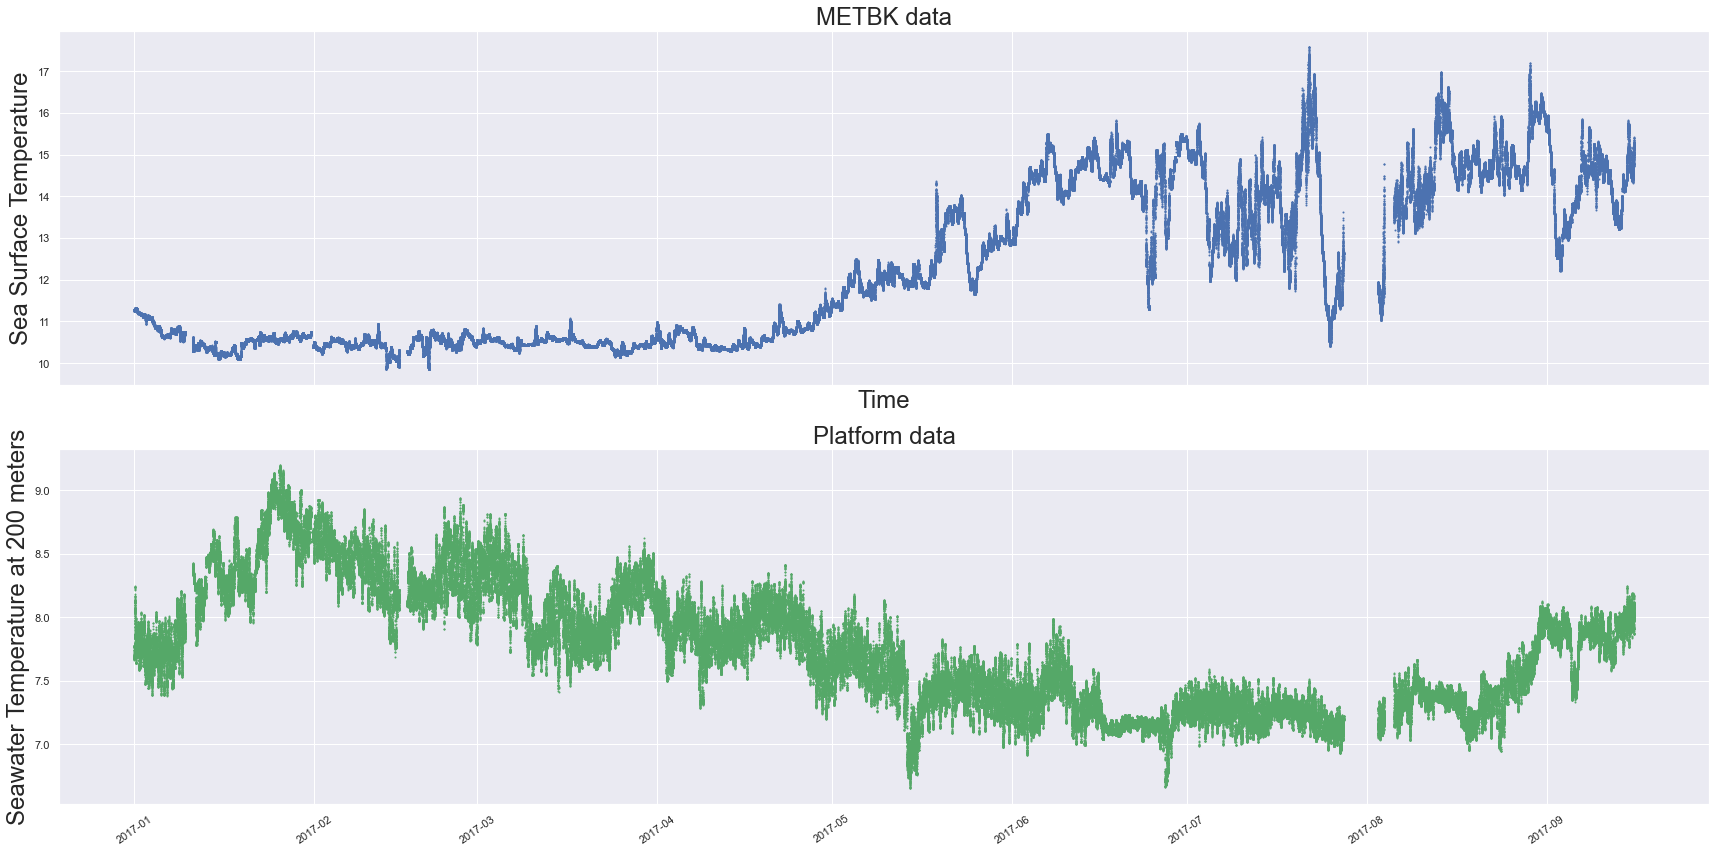

In [30]:
fig, (ax2, ax1) = plt.subplots(2,1, sharex=True, figsize = (24, 12)) 
ax1.scatter(x=df['time'], y=df['seawater_temperature'], c='g', s=1)
ax1.set_ylabel('Seawater Temperature at 200 meters', size=24)
ax1.set_title('Platform data', size=24)

ax2.scatter(x=df['time'], y=df['sea_surface_temperature'], c='b', s=1)
ax2.set_xlabel('Time', size=24)
ax2.set_ylabel('Sea Surface Temperature', size=24)
ax2.set_title('METBK data', size=24)


plt.xticks(rotation=35);
plt.tight_layout()

In the plot above we can see some areas where data is missing, but this is less than 5% of our total data so hopefully we'll survive! Next, we need to append the CUTI index data to this dataframe.

---
### Appending the CUTI index

Now we can add the upwelling index to this dataframe. First, we only need the upwelling index for the year 2017 at the location 44 degrees North, so let's grab that slice.

In [31]:
CUTI_data = CUTI_data[CUTI_data['time'].dt.year == 2017][['time', '44N']].reset_index(drop=True)

In [32]:
CUTI_data

,time,44N
0,2017-01-01,1.731
1,2017-01-02,1.308
2,2017-01-03,0.360
3,2017-01-04,0.742
4,2017-01-05,1.469
...,...,...
360,2017-12-27,0.256
361,2017-12-28,0.214
362,2017-12-29,-0.814
363,2017-12-30,-0.675


Now there are a few different ways to append this data to our dataframe. The time column in the merged dataframe is on a 1-minute resolution, but the upwelling index is on a 1-day resolution. To combine these, I loop through every month and day in our dataframe (January 01 to September 15) and grab the indices for all measurements taken on that particular day. Then I find the CUTI index value for that same date, and append it to a CUTI column in the dataframe for each date. Looping through the months and days turned out to be hugely more efficient than looping through each row in the dataframe one by one, I'm very happy with this solution!

In [33]:
for month in range(1, 10): # our dataframe only contains dates up to 2017-09-15
    for day in range(1, 32):
        try:
            indices = df[(df['time'].dt.month == month) & (df['time'].dt.day == day)].index
            cuti_value = CUTI_data.loc[(CUTI_data['time'].dt.month == month) & (CUTI_data['time'].dt.day == day)]['44N'].values[0]
            #print(month, day, cuti_value)
            df.loc[indices,'CUTI'] = cuti_value
        except:
            pass

In [34]:
df

,time,density,practical_salinity,seawater_temperature,sea_surface_temperature,CUTI
0,2017-01-01 00:00:00,1027.258767,33.916755,7.766451,11.273,1.731
1,2017-01-01 00:01:00,1027.260164,33.917475,7.760876,11.268,1.731
2,2017-01-01 00:02:00,1027.258920,33.917249,7.767207,11.267,1.731
3,2017-01-01 00:03:00,1027.258097,33.916964,7.771317,11.267,1.731
4,2017-01-01 00:04:00,1027.258173,33.917076,7.771017,11.278,1.731
...,...,...,...,...,...,...
331368,2017-09-15 23:55:00,1027.366397,33.960043,7.866675,15.198,-0.194
331369,2017-09-15 23:56:00,1027.366555,33.960125,7.866182,15.171,-0.194
331370,2017-09-15 23:57:00,1027.365319,33.959667,7.872284,15.158,-0.194
331371,2017-09-15 23:58:00,1027.364325,33.959192,7.876495,15.199,-0.194


There, now we've got the CUTI upwelling index for each measurement taken. We can one hot encode this to a binary value, because we'll be building a classifier model with two classes: upwelling, or not upwelling. To binarize this, we can say that any row where the upwelling index is positive is a 1, and every other row is a 0.

In [35]:
df['upwelling'] = df['CUTI'].apply(lambda x: 1 if x > 0 else 0)

In [36]:
df['upwelling'].value_counts(normalize=True)

1    0.612814
0    0.387186
Name: upwelling, dtype: float64

It looks like we have favorable conditions for upwelling for about 61.28% in 2017 from January 1st to September 15th.

In [37]:
df

,time,density,practical_salinity,seawater_temperature,sea_surface_temperature,CUTI,upwelling
0,2017-01-01 00:00:00,1027.258767,33.916755,7.766451,11.273,1.731,1
1,2017-01-01 00:01:00,1027.260164,33.917475,7.760876,11.268,1.731,1
2,2017-01-01 00:02:00,1027.258920,33.917249,7.767207,11.267,1.731,1
3,2017-01-01 00:03:00,1027.258097,33.916964,7.771317,11.267,1.731,1
4,2017-01-01 00:04:00,1027.258173,33.917076,7.771017,11.278,1.731,1
...,...,...,...,...,...,...,...
331368,2017-09-15 23:55:00,1027.366397,33.960043,7.866675,15.198,-0.194,0
331369,2017-09-15 23:56:00,1027.366555,33.960125,7.866182,15.171,-0.194,0
331370,2017-09-15 23:57:00,1027.365319,33.959667,7.872284,15.158,-0.194,0
331371,2017-09-15 23:58:00,1027.364325,33.959192,7.876495,15.199,-0.194,0


Here's the final dataframe! Now that everything has been properly appended along time, we can drop this column.

In [38]:
df.drop(columns=['time'], inplace=True)
df

,density,practical_salinity,seawater_temperature,sea_surface_temperature,CUTI,upwelling
0,1027.258767,33.916755,7.766451,11.273,1.731,1
1,1027.260164,33.917475,7.760876,11.268,1.731,1
2,1027.258920,33.917249,7.767207,11.267,1.731,1
3,1027.258097,33.916964,7.771317,11.267,1.731,1
4,1027.258173,33.917076,7.771017,11.278,1.731,1
...,...,...,...,...,...,...
331368,1027.366397,33.960043,7.866675,15.198,-0.194,0
331369,1027.366555,33.960125,7.866182,15.171,-0.194,0
331370,1027.365319,33.959667,7.872284,15.158,-0.194,0
331371,1027.364325,33.959192,7.876495,15.199,-0.194,0


---
### Removing outliers

Statistical analysis is a vital piece of the preprocessing process! There are a few different ways to remove outliers and you can read about them [in this article](https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba). I'm going to use the z-score to identify and remove outliers in this data.

Question: should I be removing outliers before grouping the data into upwelling/not upwelling? Aren't I artifically labeling the data here and impacting what might be considered outliers? Answer to this problem: run the z-score on the entire dataset, not on subsets grouped by upwelling/not upwelling. That way my labels aren't impacting which datapoints are identified as outliers.

These datasets are too large to put into a scatter plot, but some box plots will give us a good idea of our data distributions. 

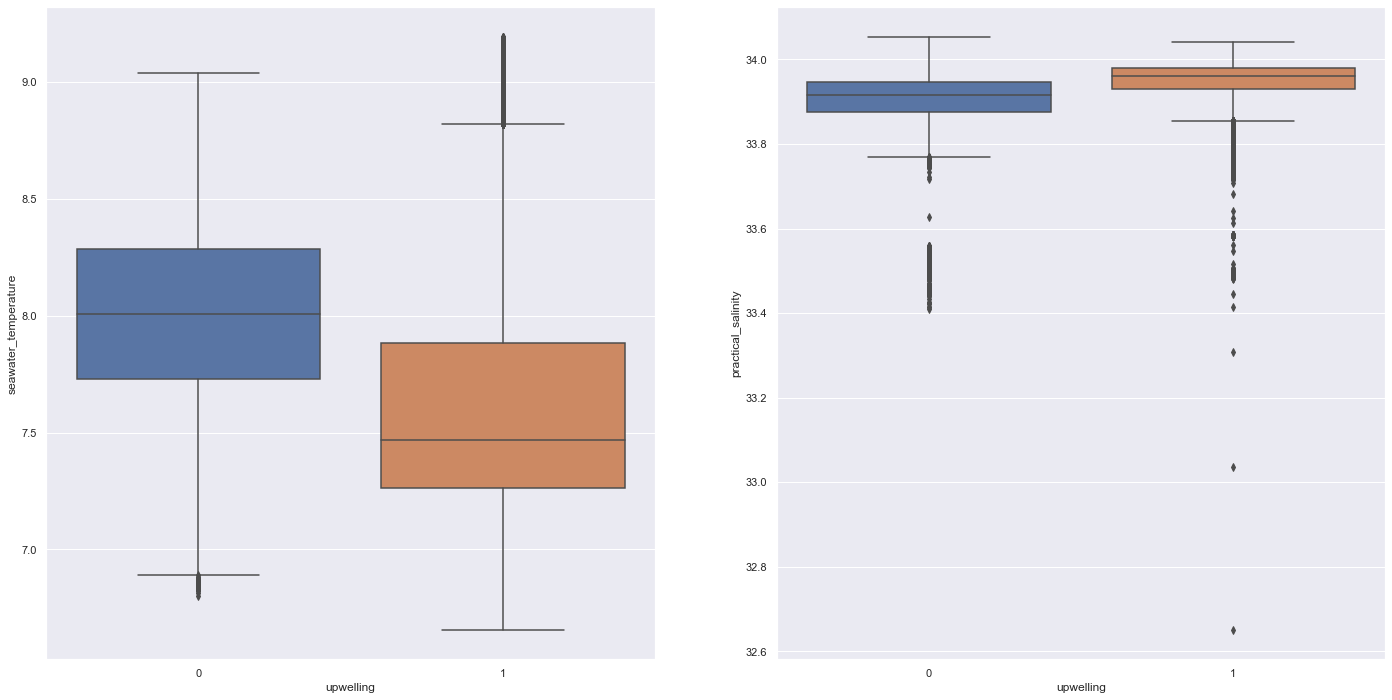

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,12))
sns.boxplot(y='seawater_temperature', x='upwelling', data=df, ax=ax1)
sns.boxplot(y='practical_salinity', x='upwelling', data=df, ax=ax2);

First of all, look at these wonderful signals of upwelling in our data! Upwelled water is colder and saltier than the alternative, just like we'd expect! But there some potential outliers here, and some pretty significant looking ones in the salinity data in particular. We should check sea surface temperatures and salinity as well. 

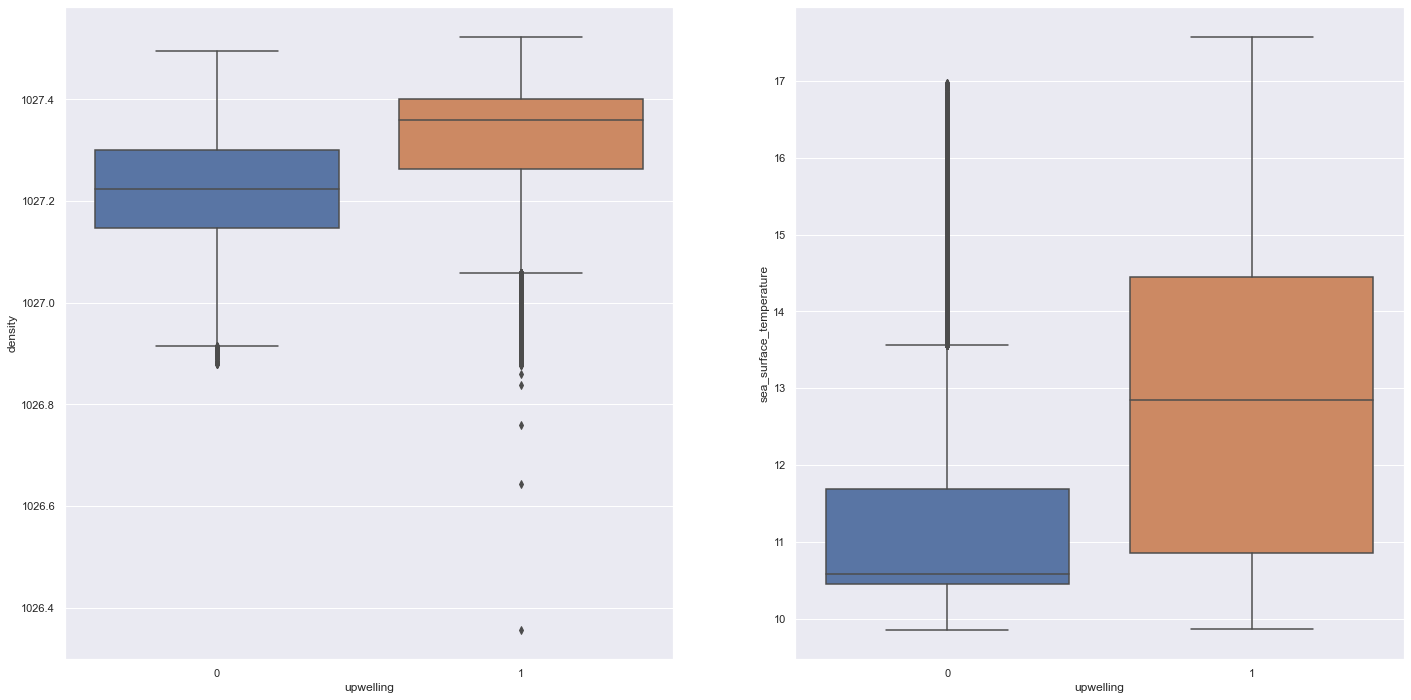

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,12))
sns.boxplot(y='density', x='upwelling', data=df, ax=ax1)
sns.boxplot(y='sea_surface_temperature', x='upwelling', data=df, ax=ax2);

Interesting that the sea surface temperature has an inverse relationship to the seawater temperature at depth. This might indicate that upwelling doesn't significantly impact the surface waters, and it's effect is limited to lower in the water column. It'll be especially interesting to see how this changes in the profiler data at various depths, but that will be for another time. For now, let's get the z-scores so we can identify and remove outliers.

In [39]:
X = df.drop(columns=['CUTI', 'upwelling'])
X

,density,practical_salinity,seawater_temperature,sea_surface_temperature
0,1027.258767,33.916755,7.766451,11.273
1,1027.260164,33.917475,7.760876,11.268
2,1027.258920,33.917249,7.767207,11.267
3,1027.258097,33.916964,7.771317,11.267
4,1027.258173,33.917076,7.771017,11.278
...,...,...,...,...
331368,1027.366397,33.960043,7.866675,15.198
331369,1027.366555,33.960125,7.866182,15.171
331370,1027.365319,33.959667,7.872284,15.158
331371,1027.364325,33.959192,7.876495,15.199


In [40]:
z = np.abs(stats.zscore(X))
print(z)

[[0.20649794 0.21969836 0.01801228 0.52792525]
 [0.19543221 0.20796728 0.00636268 0.53059759]
 [0.20528246 0.21165798 0.01959316 0.53113176]
 ...
 [0.63756723 0.47916355 0.23917984 1.54844079]
 [0.62969387 0.47142238 0.24798056 1.57035372]
 [0.60370857 0.45049675 0.27987109 1.56821554]]


In [41]:
threshold = 3
print(np.where(z > 3))

(array([ 29655,  29656,  29657, ..., 290126, 306319, 313929], dtype=int64), array([1, 1, 1, ..., 1, 1, 1], dtype=int64))


In [42]:
print(z[29655][1])

3.1981650897982283


In [43]:
clean_df = df[(z < 3).all(axis=1)]

In [52]:
print(df.shape)
print(clean_df.shape)

(331373, 6)
(329199, 6)


In [51]:
pct_outliers = 100 * (df.shape[0] - clean_df.shape[0]) / df.shape[0] 
print(f'Outliers made up {round(pct_outliers, 4)}% of the data.')

Outliers made up 0.6561% of the data.


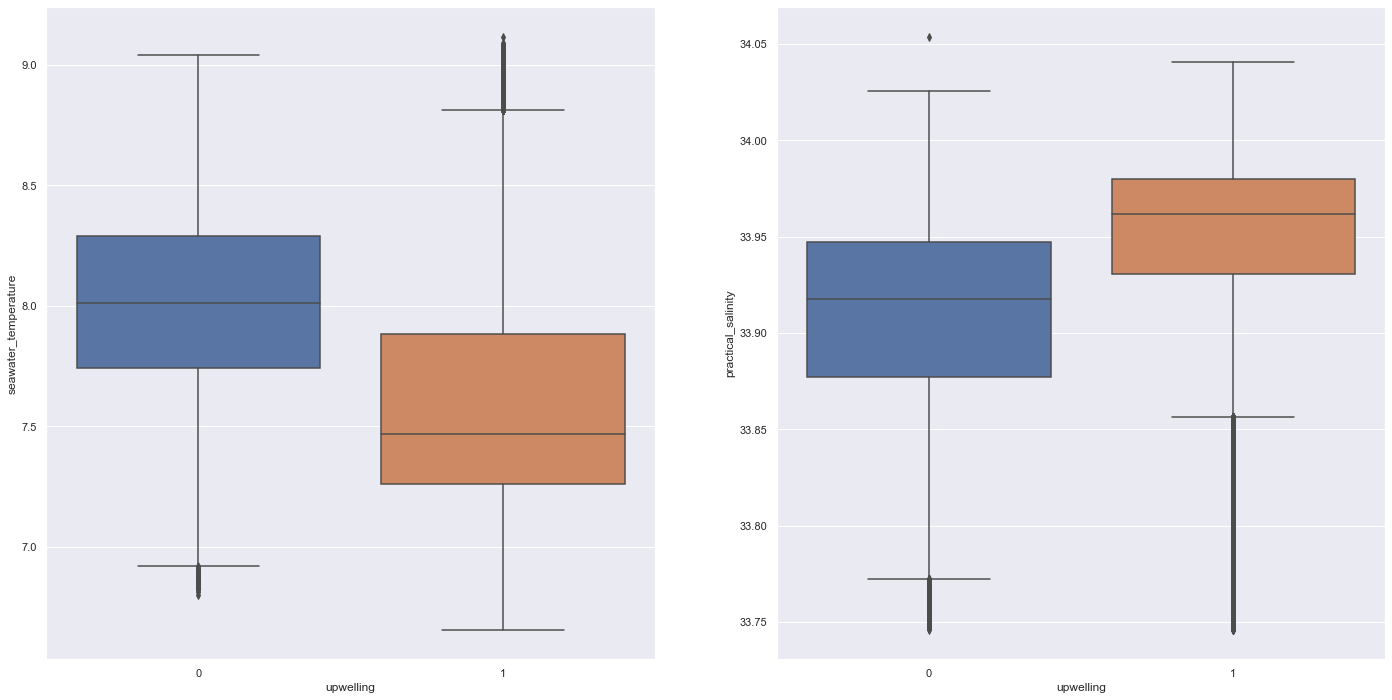

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,12))
sns.boxplot(y='seawater_temperature', x='upwelling', data=clean_df, ax=ax1)
sns.boxplot(y='practical_salinity', x='upwelling', data=clean_df, ax=ax2);

First of all, look at these wonderful signals of upwelling in our data! Upwelled water is colder and saltier than the alternative, just like we'd expect! But there some potential outliers here, and some pretty significant looking ones in the salinity data in particular. We should check sea surface temperatures and salinity as well. 

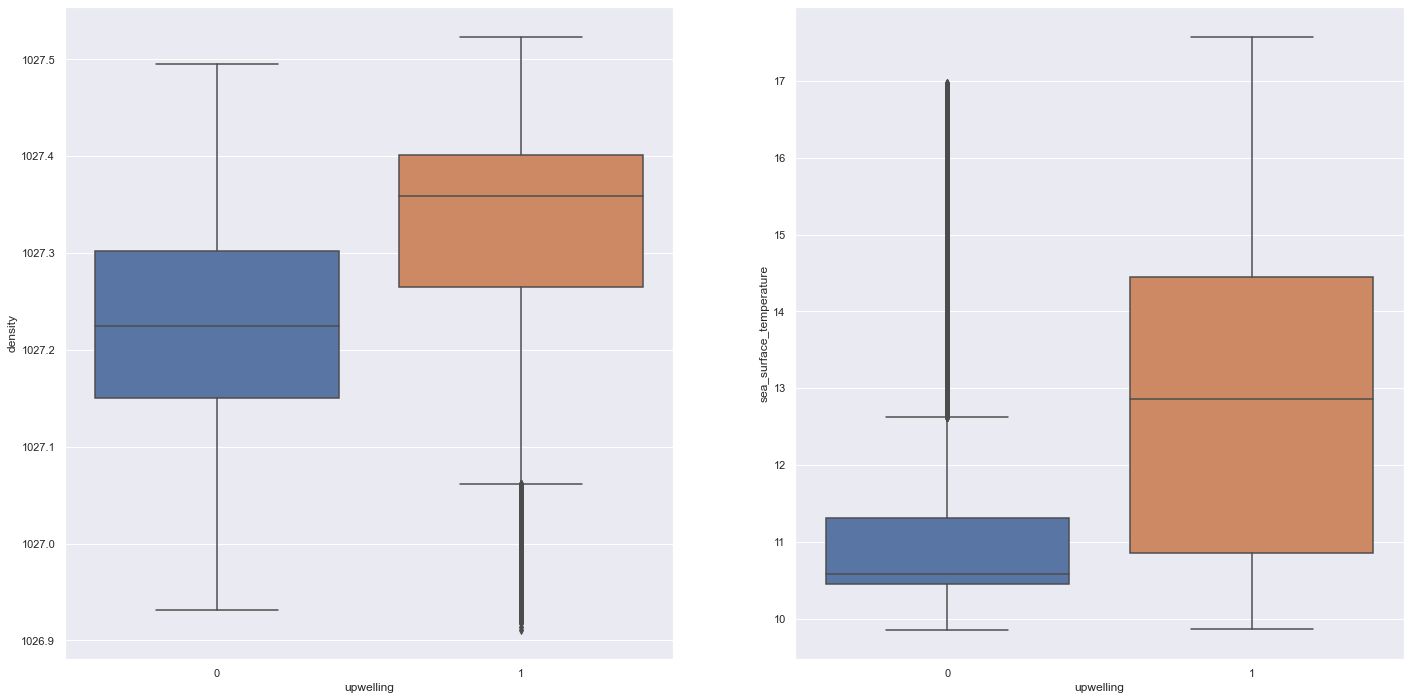

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,12))
sns.boxplot(y='density', x='upwelling', data=clean_df, ax=ax1)
sns.boxplot(y='sea_surface_temperature', x='upwelling', data=clean_df, ax=ax2);

Hey, that looks much better! Obviously there are still some data points considered outliers by the standard boxplot, but I'm satisfied with the z-score method. 

---
### Saving the clean data

This dataset might be ready for modeling now! Is there anything I'm still missing? 

In [55]:
clean_df.to_csv('../../coastal_upwelling_output/clean_dataframe.csv', index=False)